# Baseline image classification code

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=2500,
    splits={
        'train': 2000,
        'val': 500,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



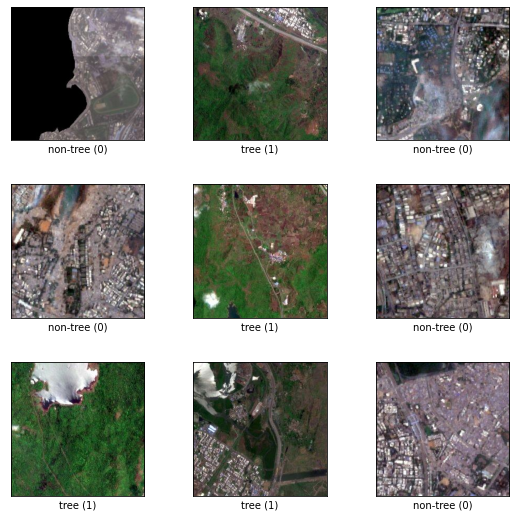

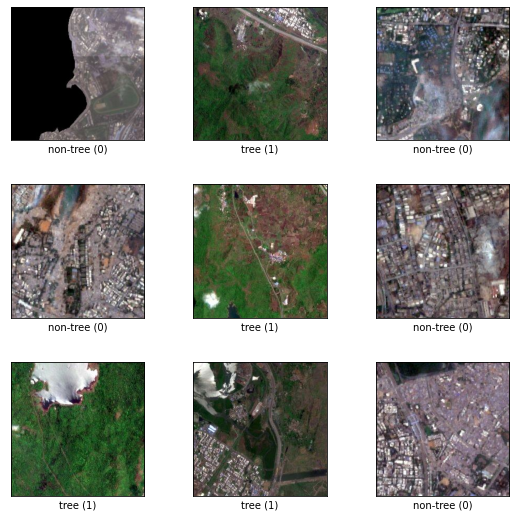

In [ ]:
import tensorflow_datasets as tfds
data_dir='/content/drive/MyDrive/treecanopy'
builder = tfds.ImageFolder('/content/drive/MyDrive/treecanopy')
print(builder.info)  # num examples, labels... are automatically calculated
ds = builder.as_dataset(split='train', shuffle_files=True)
tfds.show_examples(ds, builder.info)


Here are some roses:

And some tulips:

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2500 files belonging to 2 classes.
Using 2000 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2500 files belonging to 2 classes.
Using 500 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['train', 'val']


## Visualize the data


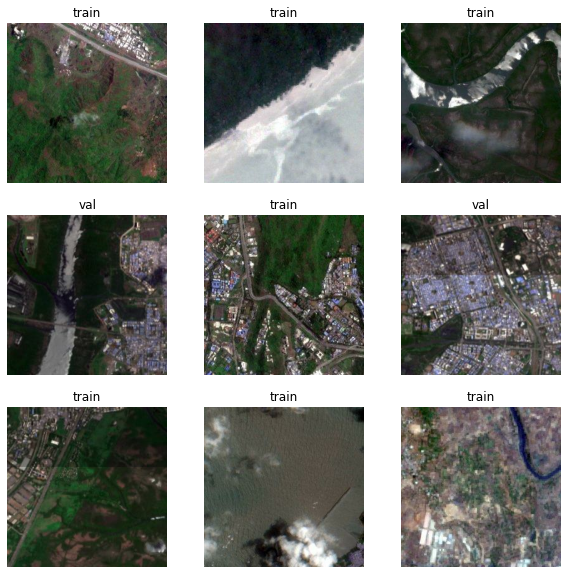

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [ ]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


# Creating the model

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `Model.summary` method:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

## Train the model

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
63/63 [==============================] - 71s 982ms/step - loss: 0.5482 - accuracy: 0.7880 - val_loss: 0.4545 - val_accuracy: 0.8020
Epoch 2/10
63/63 [==============================] - 5s 84ms/step - loss: 0.4627 - accuracy: 0.7965 - val_loss: 0.4478 - val_accuracy: 0.8040
Epoch 3/10
63/63 [==============================] - 5s 83ms/step - loss: 0.4531 - accuracy: 0.7940 - val_loss: 0.4454 - val_accuracy: 0.7960
Epoch 4/10
63/63 [==============================] - 5s 83ms/step - loss: 0.4264 - accuracy: 0.7990 - val_loss: 0.4217 - val_accuracy: 0.7980
Epoch 5/10
63/63 [==============================] - 5s 86ms/step - loss: 0.4074 - accuracy: 0.7995 - val_loss: 0.4162 - val_accuracy: 0.7960
Epoch 6/10
63/63 [==============================] - 5s 84ms/step - loss: 0.3674 - accuracy: 0.7985 - val_loss: 0.4153 - val_accuracy: 0.7880
Epoch 7/10
63/63 [==============================] - 5s 83ms/step - loss: 0.3416 - accuracy: 0.7970 - val_loss: 0.4158 - val_accuracy: 0.8040
Epoch 8/10


## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

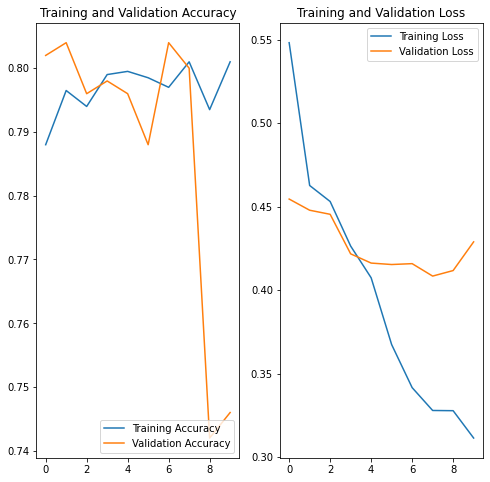

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

Let's inspect what went wrong and try to increase the overall performance of the model.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

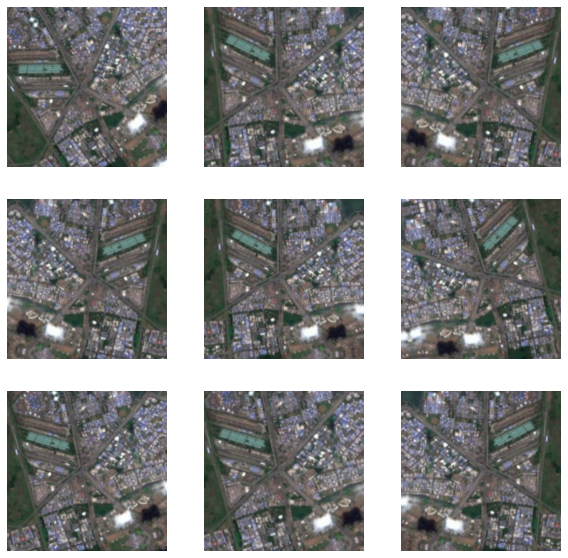

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compiling and training the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [ ]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
63/63 [==============================] - 8s 98ms/step - loss: 0.5623 - accuracy: 0.7890 - val_loss: 0.4549 - val_accuracy: 0.8000
Epoch 2/50
63/63 [==============================] - 7s 105ms/step - loss: 0.4664 - accuracy: 0.7930 - val_loss: 0.4525 - val_accuracy: 0.8040
Epoch 3/50
63/63 [==============================] - 7s 107ms/step - loss: 0.4725 - accuracy: 0.7995 - val_loss: 0.4553 - val_accuracy: 0.8040
Epoch 4/50
63/63 [==============================] - 6s 97ms/step - loss: 0.4527 - accuracy: 0.7990 - val_loss: 0.4597 - val_accuracy: 0.8040
Epoch 5/50
63/63 [==============================] - 6s 93ms/step - loss: 0.4560 - accuracy: 0.7980 - val_loss: 0.4520 - val_accuracy: 0.8040
Epoch 6/50
63/63 [==============================] - 6s 93ms/step - loss: 0.4440 - accuracy: 0.7990 - val_loss: 0.4627 - val_accuracy: 0.8040
Epoch 7/50
63/63 [==============================] - 6s 93ms/step - loss: 0.4639 - accuracy: 0.7985 - val_loss: 0.4709 - val_accuracy: 0.7940
Epoch 8/50


## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

[0.7889999747276306, 0.7929999828338623, 0.7994999885559082, 0.7990000247955322, 0.7979999780654907, 0.7990000247955322, 0.7985000014305115, 0.8009999990463257, 0.8004999756813049, 0.8004999756813049, 0.8004999756813049, 0.7990000247955322, 0.7990000247955322, 0.8004999756813049, 0.7940000295639038, 0.7990000247955322, 0.7985000014305115, 0.796500027179718, 0.8004999756813049, 0.796999990940094, 0.7985000014305115, 0.8009999990463257, 0.8019999861717224, 0.7979999780654907, 0.7975000143051147, 0.8044999837875366, 0.7994999885559082, 0.7990000247955322, 0.8004999756813049, 0.796500027179718, 0.7979999780654907, 0.8050000071525574, 0.8025000095367432, 0.7985000014305115, 0.7944999933242798, 0.8009999990463257, 0.7994999885559082, 0.8015000224113464, 0.8015000224113464, 0.8009999990463257, 0.7994999885559082, 0.8009999990463257, 0.7994999885559082, 0.8075000047683716, 0.7950000166893005, 0.8015000224113464, 0.8009999990463257, 0.8025000095367432, 0.8019999861717224, 0.8025000095367432]


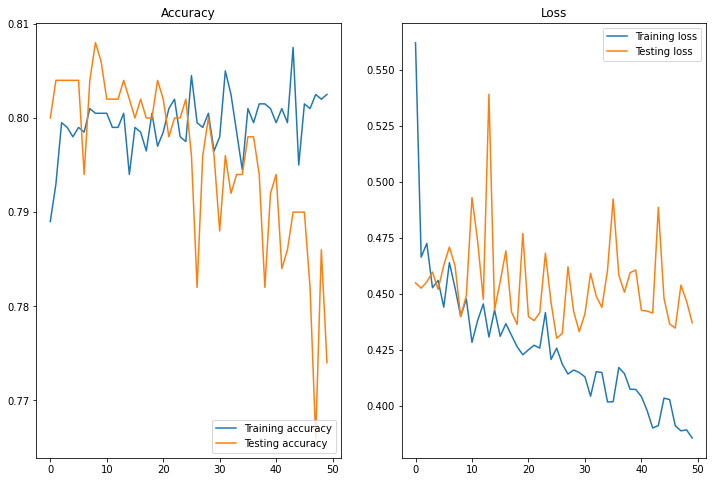

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(acc)
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Testing accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Testing loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [ ]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
test_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to val with a 93.56 percent confidence.
